In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaseball import statcast, playerid_reverse_lookup
import time

pd.options.display.max_rows=200
pd.options.display.max_columns=200
%matplotlib inline

In [2]:
def time_end(start):
    '''This function calculates the total time from an input time and prints it out'''
    end =time.time()
    el_m = int((end-start)/60)
    el_s = (end-start)-el_m*60
    print ("it took {} minutes and {:.2f} seconds to run".format(el_m, el_s))    

In [3]:
#stats=pd.read_pickle("/Users/irarickman/Google Drive/Data Science/Projects/MLB Projections/Data and Code/lastabs.pkl")
#periods={2015:["2015-04-05",'2015-10-04'],2016:["2016-04-03","2016-10-02"],2017:["2017-04-02","2017-10-01"],2018:["2018-03-29","2018-07-29"]}

In [4]:
# for yr in periods:
#     st=time.time()
#     stats=statcast(periods[yr][0],periods[yr][1])
#     stats.to_pickle("statcast{}.pkl".format(yr))
#     print("Finished {}".format(yr))
#     time_end(st)
#     print("\n")

In [7]:
latest_abs=statcast("2018-07-30","2018-08-10")

This is a large query, it may take a moment to complete
Completed sub-query from 2018-07-30 to 2018-08-04
Completed sub-query from 2018-08-05 to 2018-08-10


In [159]:
#stats=pd.concat([pd.read_pickle("statcast{}.pkl".format(yr)) for yr in range(2015,2019)])

In [6]:
stats=pd.read_pickle("../twostrikes data/statcast2015_2018.pkl")

In [10]:
stats.shape, latest_abs.shape
all_stats=pd.concat([stats,latest_abs])
all_stats.shape

(2657620, 90)

In [11]:
#getting player ids
batters=all_stats.batter.unique()
bat_nms=playerid_reverse_lookup(batters)

Gathering player lookup table. This may take a moment.


In [12]:
stats_nms=all_stats.merge(bat_nms[['name_last','name_first','key_mlbam']], how='left',left_on='batter',right_on=['key_mlbam'])
stats_nms.name_last.isnull().sum()

0

In [19]:
stats_nms.game_date.dtype

dtype('<M8[ns]')

In [21]:
stats_nms['season']=stats_nms.game_date.astype(str).apply(lambda x: x[:4])
stats_nms.season.value_counts()

2017    721243
2016    716185
2015    702492
2018    517700
Name: season, dtype: int64

In [32]:
## Filtering down fields
keep=['player_name','season','name_first','name_last','balls','strikes','events','description','launch_speed','estimated_woba_using_speedangle','estimated_ba_using_speedangle']
df=stats_nms[keep]
df['batter_name']=df.name_first.str.capitalize() + " " + df.name_last.str.capitalize()
df.rename(columns={"player_name":"pitcher_name","estimated_woba_using_speedangle":"xwoba","estimated_ba_using_speedangle":"xba"},inplace=True)
df.drop(['name_first','name_last'],axis=1,inplace=True)
df['two_strike']=df.strikes==2
df['hit']=df.events.apply(lambda x: 1 if x in ["single",'double','home_run','triple'] else 0)
df['ab']=df.events.apply(lambda x: 0 if x in ['walk','hit_by_pitch',"caught_stealing_2b","pickoff_caught_stealing_2b",'pickoff_1b','catcher_interf','pickoff_caught_stealing_3b','pickoff_2b','pickoff_caught_stealing_home','caught_stealing_3b','caught_stealing_home',"sac_fly",'sac_bunt','sac_fly_double_play','sac_bunt_double_play'] else 1)
df_only_abs=df[df.events.notnull()]

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [33]:
df_only_abs.shape

(686430, 13)

In [34]:
df_only_abs.to_pickle("../twostrikes data/statcast_prepped.pkl")
df_only_abs.to_csv("../twostrikes data/statcast_prepped.csv")

In [57]:
df_only_abs.head()

pitcher_name season  balls  strikes                     events  \
0   Jeurys Familia   2015    0.0      1.0                  field_out   
2   Jeurys Familia   2015    0.0      0.0                     double   
3   Jeurys Familia   2015    3.0      2.0                  strikeout   
10  Jeurys Familia   2015    3.0      1.0                  field_out   
15   Blake Treinen   2015    2.0      1.0  grounded_into_double_play   

             description  launch_speed  xwoba    xba     batter_name  \
0          hit_into_play          95.2  0.253  0.132    Jayson Werth   
2   hit_into_play_no_out          72.2  0.089  0.088    Bryce Harper   
3        swinging_strike           NaN    NaN    NaN     Trea Turner   
10         hit_into_play          93.9  0.344  0.376  Anthony Rendon   
15         hit_into_play         102.7  0.186  0.200   Daniel Murphy   

    two_strike  hit  ab        player_season        batter_season  
0        False    0   1    Jayson Werth_2015    Jayson Werth_2015  
2        False    1   1    Bryce Harper_2015    Bryce Harper_2015  
3         True    0   1     Trea Turner_2015     Trea Turner_2015  
10       False    0   1  Anthony Rendon_2015  Anthony Rendon_2015  
15       False    0   1   Daniel Murphy_2015   Daniel Murphy_2015

creating the sampling logic for launch speed, xwoba, and ba 

** I'll do this another time - but worth checking out congeneric reliability to calculate this**
also check out this link - https://www.fangraphs.com/blogs/a-new-way-to-look-at-sample-size-math-supplement/

To do this
1. Write a function to take a random sample of different sizes of n
2. Sample each player-season using those functions
3. Calculate the stat for those sample sizes
4. Calculate the cronbach's alpha thing, which calculates the stability
5. Graph the sample sizes so I can see where reliability starts to improve, by sample size

### Aims of this quick analysis

1. Identify any players seasons with a better two strike average than not
2. Identify better measures of this and discuss - i.e. woba, xwoba, and launch speed
3. Lay the groundwork to test the reliability of each measure

To accomplish this and prepare it for a blog post, I need to make my visualizations look better so they are production ready. From a flow perspective, I think I want to highlight the top 20 biggest and smallest differences in each, present a scatter demonstrating the relationship between strikeouts and two strike average differences and other measures. Then close with a discussion on reliability and proper ways to measure it. If I feel like it, I should also look at pitchers who do a good job of this too

In [95]:
## getting players with more than 370 PAs since they probably play a lot and also it seems like a good spot for reliability for wOBA and launch speed and ok for BA
#bat_pas=df.batter_name.value_counts()
#batters=bat_pas[bat_pas>100].index.tolist()

bat_PAs=df_only_abs.groupby(['batter_name','season'])['ab'].count().reset_index().rename(columns={'ab':'num_pas'})
bat_PAs['batter_season']=bat_PAs.batter_name + "_" + bat_PAs.season
batters=bat_PAs[bat_PAs.num_pas>=300]['batter_season'].tolist()
df_only_abs['batter_season']=df_only_abs.batter_name + "_" + df_only_abs.season
batter_df=df_only_abs[df_only_abs.batter_season.isin(batters)]
print("Batter df shape {}".format(batter_df.shape))

pit_PAs=df_only_abs.groupby(['pitcher_name','season'])['ab'].count().reset_index().rename(columns={'ab':'num_pas'})
pit_PAs['pitcher_season']=pit_PAs.pitcher_name + "_" + pit_PAs.season
pitchers=pit_PAs[pit_PAs.num_pas>=300]['pitcher_season'].tolist()
df_only_abs['pitcher_season']=df_only_abs.pitcher_name + "_" + df_only_abs.season
pitcher_df=df_only_abs[df_only_abs.pitcher_season.isin(pitchers)]
print("Pitcher df shape {}".format(pitcher_df.shape))

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Batter df shape (505949, 16)
Pitcher df shape (409928, 16)


/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [96]:
pitcher_df.head()

pitcher_name season  balls  strikes     events           description  \
0   Jeurys Familia   2015    0.0      1.0  field_out         hit_into_play   
2   Jeurys Familia   2015    0.0      0.0     double  hit_into_play_no_out   
3   Jeurys Familia   2015    3.0      2.0  strikeout       swinging_strike   
10  Jeurys Familia   2015    3.0      1.0  field_out         hit_into_play   
31  Tyler Clippard   2015    0.0      2.0  strikeout       swinging_strike   

    launch_speed  xwoba    xba      batter_name  two_strike  hit  ab  \
0           95.2  0.253  0.132     Jayson Werth       False    0   1   
2           72.2  0.089  0.088     Bryce Harper       False    1   1   
3            NaN    NaN    NaN      Trea Turner        True    0   1   
10          93.9  0.344  0.376   Anthony Rendon       False    0   1   
31           NaN    NaN    NaN  Matt Den dekker        True    0   1   

           player_season         batter_season       pitcher_season  
0      Jayson Werth_2015     Jayson Werth_2015  Jeurys Familia_2015  
2      Bryce Harper_2015     Bryce Harper_2015  Jeurys Familia_2015  
3       Trea Turner_2015      Trea Turner_2015  Jeurys Familia_2015  
10   Anthony Rendon_2015   Anthony Rendon_2015  Jeurys Familia_2015  
31  Matt Den dekker_2015  Matt Den dekker_2015  Tyler Clippard_2015

In [100]:
## function to filter for me
def two_strikes(met,nms=batters, pos="batter_season",dframe=batter_df):
    d=dframe[dframe[pos].isin(nms)]
    if met=="avg":
        av=d[[pos,"two_strike",'hit','ab']].groupby([pos,'two_strike']).sum()
        av['avg']=av.hit/av.ab.astype(float)
        av.reset_index(inplace=True)
        a=av.pivot(pos,"two_strike",'avg').rename(columns={True:"Two Strikes",False:"All Other Counts"})
        a['Difference']=a["Two Strikes"]-a["All Other Counts"]
        a.reset_index(inplace=True)
        pos_spot=pos.split("_")[0].capitalize()
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes","Difference"]].sort_values(['Difference'], ascending=False)
    elif met=="xwoba":
        av=d[[pos,"two_strike",'xwoba']].groupby([pos,'two_strike']).mean()
        av.reset_index(inplace=True)
        a= av.pivot(pos,"two_strike",'xwoba').rename(columns={True:"Two Strikes",False:"All Other Counts"})
        a.reset_index(inplace=True)
        a['Difference']=a["Two Strikes"]-a["All Other Counts"]
        pos_spot=pos.split("_")[0].capitalize()
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes","Difference"]].sort_values(['Difference'], ascending=False)
    elif met=="launch_speed":
        av=d[[pos,"two_strike",'launch_speed']].groupby([pos,'two_strike']).mean()
        av.reset_index(inplace=True)
        a= av.pivot(pos,"two_strike",'launch_speed').rename(columns={True:"Two Strikes",False:"All Other Counts"})
        a.reset_index(inplace=True)
        a['Difference']=a["Two Strikes"]-a["All Other Counts"]
        pos_spot=pos.split("_")[0].capitalize()
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes","Difference"]].sort_values(['Difference'], ascending=False)
    elif met=="xba":
        av=d[[pos,"two_strike",'xba']].groupby([pos,'two_strike']).mean()
        av.reset_index(inplace=True)
        a= av.pivot(pos,"two_strike",'xba').rename(columns={True:"Two Strikes",False:"All Other Counts"})
        a.reset_index(inplace=True)
        a['Difference']=a["Two Strikes"]-a["All Other Counts"]
        pos_spot=pos.split("_")[0].capitalize()
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes","Difference"]].sort_values(['Difference'], ascending=False)
    elif met=="hits":
        av=d[[pos,"two_strike",'hit']].groupby([pos,'two_strike']).sum()
        av.reset_index(inplace=True)
        a=av.pivot(pos,"two_strike","hit").rename(columns={True:"Two Strikes",False:"All Other Counts"})
        a.reset_index(inplace=True)
        pos_spot=pos.split("_")[0].capitalize()
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes"]]
    elif met=="abs":
        av=d[[pos,"two_strike",'ab']].groupby([pos,'two_strike']).sum()
        av.reset_index(inplace=True)
        pos_spot=pos.split("_")[0].capitalize()
        a.reset_index(inplace=True)
        a[pos_spot]=a[pos].apply(lambda x: x.split("_")[0])
        a["Season"]=a[pos].apply(lambda x: x.split("_")[1])
        return a[[pos_spot,"Season","All Other Counts","Two Strikes"]]

In [120]:
two_strikes_avg.head()

two_strike             Batter Season All Other Counts Two Strikes Difference
561             Jose Iglesias   2015             .291        .307       .016
73          Andrelton Simmons   2018             .303        .316       .013
458               James Loney   2015             .278        .273     -0.005
220               Chase Utley   2017             .242        .229     -0.013
510                 Joe Mauer   2016             .273        .243      -0.03

In [141]:
def avg_form(x):
    if str(x)[0]=="-":
        return "-" + str(round(x,3))[2:]
    else:
        return str(round(x,3)).strip("0")

In [174]:
two_strikes_avg=two_strikes('avg')
for x in ['Two Strikes',"All Other Counts","Difference"]:
    two_strikes_avg[x]=two_strikes_avg[x].apply(lambda x: avg_form(x))

two_strikes_avg.set_index(["Batter","Season"],inplace=True)
two_strikes_avg.rename_axis(None,axis="columns",inplace=True)
two_strikes_avg.style.set_properties({"background-color":'white'},inplace=True)
two_strikes_avg.head(20)
#two_strikes_avg.style.format({"Two Strikes":lambda x: avg_form(x),"All Other Counts":lambda x: avg_form(x),"Difference":lambda x: avg_form(x)})


All Other Counts Two Strikes Difference
Batter            Season                                        
Jose Iglesias     2015               .291        .307       .016
Andrelton Simmons 2018               .303        .316       .013
James Loney       2015               .278        .273      -.005
Chase Utley       2017               .242        .229      -.013
Joe Mauer         2016               .273        .243       -.03
Christian Vazquez 2017               .307        .275      -.032
Ichiro Suzuki     2016               .308        .273      -.034
Brandon Phillips  2016               .306        .271      -.035
Matt Duffy        2016               .272        .236      -.037
Jason Heyward     2016               .247        .209      -.038
Robbie Grossman   2018               .273        .233       -.04
Nick Ahmed        2016               .234        .194       -.04
Jose Reyes        2015               .292        .251      -.041
Jose Peraza       2017               .277        .236      -.041
Martin Prado      2016               .323        .281      -.042
Kyle Seager       2018                .25        .206      -.044
Angel Pagan       2015               .282        .237      -.045
Ben Zobrist       2015               .295         .25      -.045
Mookie Betts      2017               .289         .24      -.049
Corey Dickerson   2018               .337        .286      -.051

In [86]:
## Sorting on two strike abs
two_strikes_avg=two_strikes('avg').sort_values(['diff'])
two_strikes_avg.reset_index(inplace=True)
two_strikes_avg['Batter']=two_strikes_avg.batter_season.apply(lambda x: x.split("_")[0])
two_strikes_avg['Season']=two_strikes_avg.batter_season.apply(lambda x: x.split("_")[1])
two_strikes_avg.head()

two_strike           batter_season  All Other Counts  Two Strikes      diff  \
0               Jose Iglesias_2015          0.291080     0.307317 -0.016237   
1           Andrelton Simmons_2018          0.302682     0.316176 -0.013494   
2                 James Loney_2015          0.277778     0.272727  0.005051   
3                 Chase Utley_2017          0.242424     0.229167  0.013258   
4                   Joe Mauer_2016          0.273148     0.243056  0.030093   

two_strike             Batter Season  
0               Jose Iglesias   2015  
1           Andrelton Simmons   2018  
2                 James Loney   2015  
3                 Chase Utley   2017  
4                   Joe Mauer   2016

In [47]:
df_avg.head()

two_strike                 False      True      diff
player_season                                       
Jose Iglesias_2015      0.291080  0.307317 -0.016237
Andrelton Simmons_2018  0.302682  0.316176 -0.013494
James Loney_2015        0.277778  0.272727  0.005051
Chase Utley_2017        0.242424  0.229167  0.013258
Joe Mauer_2016          0.273148  0.243056  0.030093

In [49]:
df_avg=two_strikes(seasons, 'player_season','avg')
df_k=season_df[season_df.events.str.contains("strikeout")][['player_season','events']].groupby(['player_season']).count()
df_k.rename(columns={"events":'strikeouts'},inplace=True)
df_bb=season_df[season_df.events.str.contains("walk")][['player_season','events']].groupby(['player_season']).count()
df_bb.rename(columns={"events":'walks'},inplace=True)
df_avg_plus=df_avg.merge(df_k,how='left',right_index=True,left_index=True).merge(df_bb, how='left',left_index=True,right_index=True)

In [50]:
len(df_avg_plus.strikeouts),len(df_avg_plus['diff'])

(940, 940)

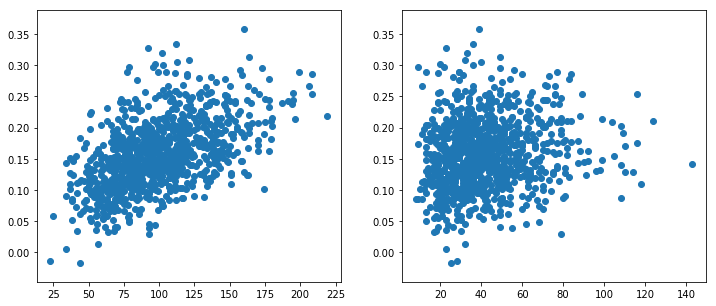

In [51]:
## scatter of difference against strikeouts
p=plt.figure(figsize=(12,5))
ax1=p.add_subplot(121)
ax1.scatter(df_avg_plus.strikeouts, df_avg_plus['diff'])
ax2=p.add_subplot(122)
ax2.scatter(df_avg_plus.walks, df_avg_plus['diff'])

In [52]:
two_strikes(seasons, "player_season",'launch_speed')

two_strike                     False       True      diff
player_season                                            
Billy Hamilton_2015        76.706977  83.437778 -6.730801
Mike Zunino_2015           84.270290  89.923913 -5.653623
Danny Espinosa_2016        84.349789  89.755462 -5.405673
Cory Spangenberg_2015      81.247647  86.384058 -5.136411
Carlos Gomez_2015          84.801826  89.472269 -4.670442
Delino Deshields_2017      77.087500  81.676000 -4.588500
Jason Castro_2016          87.296053  91.852727 -4.556675
Jake Marisnick_2015        81.405031  85.834118 -4.429086
Michael Bourn_2016         80.241667  84.475200 -4.233533
Travis Jankowski_2016      81.228302  85.424691 -4.196389
Willson Contreras_2017     85.575000  89.572727 -3.997727
Carlos Gomez_2016          83.969565  87.770213 -3.800648
Giancarlo Stanton_2018     92.301596  96.050413 -3.748817
Jose Peraza_2018           82.172109  85.872881 -3.700773
Alejandro De aza_2015      82.753061  86.397959 -3.644898
Jonathan Villar_2016       86.521484  90.132738 -3.611254
Gorkys Hernandez_2017      82.173050  85.757000 -3.583950
Nick Ahmed_2015            82.586147  86.099145 -3.512998
Javier Baez_2016           84.817172  88.319167 -3.501995
Byron Buxton_2017          83.686700  87.128205 -3.441506
Scooter Gennett_2015       83.360204  86.541441 -3.181237
Chris Young_2015           83.786585  86.960674 -3.174089
Welington Castillo_2017    88.114085  91.176923 -3.062839
Trea Turner_2018           86.848246  89.894444 -3.046199
Billy Hamilton_2016        78.794581  81.811024 -3.016442
Carlos Sanchez_2015        83.089785  86.057364 -2.967579
Adeiny Hechavarria_2015    85.602817  88.541818 -2.939001
Brandon Nimmo_2018         89.063566  91.821429 -2.757863
Yasmani Grandal_2016       89.849068  92.545614 -2.696546
Carlos Gomez_2017          85.978409  88.546154 -2.567745
Matt Carpenter_2017        87.692079  90.198870 -2.506791
Adam Lind_2015             88.444726  90.926190 -2.481465
Delino Deshields_2015      80.835500  83.304444 -2.468944
Steven Souza_2017          86.937143  89.333645 -2.396502
Anthony Gose_2015          84.465865  86.839850 -2.373984
Alex Avila_2017            89.859167  92.190411 -2.331244
Mallex Smith_2018          83.196023  85.495556 -2.299533
Billy Hamilton_2018        78.131544  80.417699 -2.286155
Jose Reyes_2015            82.125965  84.376027 -2.250062
Tommy Joseph_2017          88.324786  90.571852 -2.247066
Tim Anderson_2016          85.920430  88.144737 -2.224307
Rougned Odor_2018          85.540854  87.751389 -2.210535
Marwin Gonzalez_2017       86.395928  88.601408 -2.205481
Matt Holliday_2017         89.034337  91.237755 -2.203418
Danny Valencia_2016        89.052423  91.242424 -2.190001
Justin Bour_2018           87.703425  89.851667 -2.148242
Carlos Gonzalez_2016       89.418553  91.515217 -2.096664
Cody Asche_2015            85.766822  87.849505 -2.082683
Cory Spangenberg_2017      83.867431  85.928431 -2.061000
Carlos Gonzalez_2018       88.810795  90.812500 -2.001705
Freddy Galvis_2018         86.276720  88.272464 -1.995744
Trevor Story_2017          87.732292  89.695122 -1.962830
Michael Taylor_2018        85.334146  87.256122 -1.921976
Todd Frazier_2016          87.733468  89.655263 -1.921795
Freddy Galvis_2016         84.654770  86.565556 -1.910785
David Ortiz_2016           92.091186  93.996951 -1.905765
Jackie Bradley_2018        90.931169  92.834043 -1.902874
Francisco Lindor_2015      86.372222  88.251402 -1.879180
Starling Marte_2015        85.562712  87.432941 -1.870229
Odubel Herrera_2017        85.666803  87.496250 -1.829447
Rougned Odor_2017          87.706485  89.524841 -1.818356
Maikel Franco_2018         87.569231  89.337755 -1.768524
Keon Broxton_2017          84.940268  86.674227 -1.733958
Jay Bruce_2015             89.087829  90.795000 -1.707171
Will Venable_2015          85.081646  86.759596 -1.677950
Marwin Gonzalez_2016       85.451004  87.110317 -1.659313
Marwin Gonzalez_2015       85.997283  87.623656 -1.62637

In [53]:
two_strikes(seasons, "player_season",'xwoba')

two_strike                  False      True      diff
player_season                                        
Mike Zunino_2015         0.283225  0.468286 -0.185061
Carlos Gonzalez_2018     0.339972  0.464455 -0.124483
Javier Baez_2016         0.302589  0.404874 -0.102285
Brad Miller_2017         0.334351  0.432519 -0.098168
Niko Goodrum_2018        0.377920  0.473234 -0.095314
Justin Smoak_2016        0.424441  0.514217 -0.089776
Carlos Gomez_2017        0.402390  0.491013 -0.088623
Jason Castro_2016        0.397454  0.485745 -0.088292
Cody Asche_2015          0.334117  0.421455 -0.087339
Keon Broxton_2017        0.411265  0.493021 -0.081756
Danny Espinosa_2016      0.323046  0.403966 -0.080919
Jake Marisnick_2015      0.301893  0.381624 -0.079730
Chris Young_2015         0.300622  0.379764 -0.079142
Yasmani Grandal_2016     0.407621  0.482070 -0.074449
Jason Heyward_2016       0.288931  0.361556 -0.072625
Marwin Gonzalez_2018     0.339849  0.412159 -0.072310
Giancarlo Stanton_2018   0.450882  0.522958 -0.072077
Colin Moran_2018         0.368442  0.440506 -0.072064
Danny Valencia_2016      0.390580  0.458902 -0.068322
Brandon Moss_2017        0.453086  0.521271 -0.068184
Preston Tucker_2015      0.331909  0.398690 -0.066781
Carlos Gomez_2015        0.326680  0.392664 -0.065984
Todd Frazier_2016        0.349976  0.413857 -0.063882
Welington Castillo_2017  0.433528  0.497337 -0.063808
Trey Mancini_2017        0.402787  0.466550 -0.063763
Miguel Andujar_2018      0.376579  0.440280 -0.063701
Jordy Mercer_2018        0.364748  0.428025 -0.063277
Asdrubal Cabrera_2015    0.313093  0.376358 -0.063265
Yan Gomes_2015           0.372609  0.435165 -0.062556
Curtis Granderson_2015   0.385067  0.447262 -0.062194
Rafael Devers_2018       0.374027  0.433274 -0.059247
Carlos Gonzalez_2016     0.390113  0.448174 -0.058061
Kendrys Morales_2018     0.464415  0.522034 -0.057619
Nick Williams_2018       0.442450  0.499737 -0.057287
Christian Vazquez_2017   0.319490  0.374259 -0.054769
Maikel Franco_2018       0.349178  0.403143 -0.053965
Brandon Moss_2015        0.414593  0.468318 -0.053725
Hernan Perez_2016        0.313862  0.367008 -0.053146
Yonder Alonso_2015       0.325502  0.376817 -0.051315
Kevin Pillar_2018        0.345943  0.395754 -0.049811
Rougned Odor_2017        0.345628  0.394442 -0.048814
Yasmani Grandal_2018     0.417356  0.465802 -0.048446
Jason Castro_2015        0.350811  0.399128 -0.048317
Billy Hamilton_2016      0.246414  0.294630 -0.048216
James Loney_2015         0.297983  0.344747 -0.046765
Evan Gattis_2016         0.388173  0.434577 -0.046404
Coco Crisp_2016          0.292639  0.338970 -0.046331
Pedro Alvarez_2016       0.434728  0.480679 -0.045951
Freddy Galvis_2016       0.302298  0.346050 -0.043752
Odubel Herrera_2017      0.361016  0.404686 -0.043669
Kyle Seager_2018         0.380596  0.421280 -0.040684
Gorkys Hernandez_2018    0.395289  0.435901 -0.040613
Travis Shaw_2018         0.376000  0.416236 -0.040236
Chase Utley_2016         0.340416  0.380603 -0.040187
Jose Reyes_2015          0.253632  0.293507 -0.039875
Jacoby Jones_2018        0.367578  0.406792 -0.039214
Tim Anderson_2018        0.336014  0.374680 -0.038666
Matt Carpenter_2015      0.446726  0.485353 -0.038628
Yan Gomes_2017           0.328759  0.366547 -0.037787
Adonis Garcia_2016       0.358060  0.394994 -0.036934
Justin Bour_2018         0.400089  0.436892 -0.036803
Michael Bourn_2016       0.291131  0.327872 -0.036741
Justin Upton_2015        0.387225  0.422142 -0.034917
Jose Reyes_2017          0.286222  0.321090 -0.034869
Nick Hundley_2015        0.317100  0.351946 -0.034846
Anthony Rendon_2015      0.344593  0.377082 -0.032489
Justin Upton_2017        0.452532  0.485000 -0.032468
Tommy Pham_2018          0.444448  0.476882 -0.032433
Kole Calhoun_2018        0.416098  0.447795 -0.031697
Justin Upton_2016        0.436633  0.468257 -0.031624
Derek Norris_2015        0.299867  0.331414 -0.031547
Ben Zobrist_2015         0.307805  0.339294 -0.031489
Adam

In [54]:
two_strikes(seasons, "player_season",'xba')

two_strike                 False      True      diff
player_season                                       
Mike Zunino_2015        0.245580  0.366769 -0.121190
Jordy Mercer_2018       0.321406  0.406729 -0.085322
Carlos Gonzalez_2018    0.308506  0.391688 -0.083183
Jake Marisnick_2015     0.267453  0.344600 -0.077147
Nick Williams_2018      0.369649  0.443934 -0.074285
Carlos Gomez_2017       0.338994  0.412494 -0.073499
Jason Heyward_2016      0.277585  0.350311 -0.072726
Marwin Gonzalez_2018    0.296704  0.368907 -0.072202
Javier Baez_2016        0.274898  0.346084 -0.071186
Brad Miller_2017        0.288788  0.358630 -0.069842
Coco Crisp_2016         0.263780  0.333000 -0.069220
Hernan Perez_2016       0.282852  0.351678 -0.068826
Justin Smoak_2016       0.346409  0.414633 -0.068224
James Loney_2015        0.288848  0.356727 -0.067879
Christian Vazquez_2017  0.298536  0.363565 -0.065029
Jason Castro_2016       0.334118  0.398364 -0.064245
Colin Moran_2018        0.326145  0.386753 -0.060608
Curtis Granderson_2015  0.322433  0.381395 -0.058962
Michael Bourn_2016      0.270762  0.329576 -0.058814
Robbie Grossman_2016    0.332955  0.391321 -0.058366
Miguel Andujar_2018     0.326930  0.385075 -0.058145
Danny Espinosa_2016     0.268232  0.326353 -0.058121
Yan Gomes_2015          0.318316  0.376154 -0.057838
Kyle Seager_2018        0.316498  0.369076 -0.052578
Caleb Joseph_2015       0.301424  0.353040 -0.051616
Kevin Pillar_2018       0.312795  0.364341 -0.051546
Cody Asche_2015         0.309785  0.360990 -0.051205
Billy Hamilton_2016     0.254448  0.304866 -0.050418
Odubel Herrera_2017     0.321650  0.370912 -0.049262
Todd Frazier_2016       0.283720  0.332825 -0.049106
Kendrys Morales_2018    0.369136  0.417523 -0.048387
Maikel Franco_2018      0.306322  0.354327 -0.048004
Adrian Beltre_2017      0.310911  0.358569 -0.047659
Kole Calhoun_2018       0.330276  0.377818 -0.047542
Yasmani Grandal_2018    0.320978  0.368302 -0.047324
Adonis Garcia_2016      0.326866  0.373513 -0.046647
Danny Valencia_2016     0.346124  0.391159 -0.045035
Carlos Gomez_2015       0.296288  0.341252 -0.044964
Brandon Moss_2017       0.347298  0.391682 -0.044384
Matt Holliday_2016      0.312035  0.356418 -0.044384
Giancarlo Stanton_2018  0.359565  0.403642 -0.044077
Jose Reyes_2015         0.257218  0.301137 -0.043919
Travis Shaw_2018        0.304642  0.348462 -0.043820
Niko Goodrum_2018       0.318864  0.362457 -0.043593
Freddy Galvis_2016      0.277660  0.320782 -0.043123
Matt Carpenter_2015     0.365779  0.406289 -0.040510
Matt Holliday_2017      0.331054  0.371500 -0.040446
Trey Mancini_2017       0.340328  0.380700 -0.040372
Jason Castro_2015       0.311635  0.351897 -0.040262
Tommy Joseph_2017       0.317286  0.357378 -0.040091
Jose Reyes_2017         0.266273  0.306277 -0.040005
Asdrubal Cabrera_2018   0.333053  0.372597 -0.039543
Chris Young_2015        0.282543  0.321820 -0.039278
Jacoby Jones_2018       0.319039  0.357558 -0.038519
Preston Tucker_2015     0.304477  0.342750 -0.038273
Jose Iglesias_2018      0.265351  0.303338 -0.037987
Chase Utley_2016        0.315202  0.353179 -0.037978
Christian Yelich_2015   0.353124  0.391092 -0.037967
Gorkys Hernandez_2018   0.336845  0.374679 -0.037834
Joey Wendle_2018        0.322024  0.359604 -0.037580
Jose Iglesias_2015      0.251482  0.288733 -0.037251
Zack Cozart_2017        0.297861  0.334564 -0.036704
Justin Upton_2017       0.352305  0.388981 -0.036676
Aaron Hicks_2018        0.334513  0.370935 -0.036422
Nick Hundley_2015       0.294694  0.330351 -0.035657
Rafael Devers_2018      0.319321  0.354874 -0.035553
Addison Russell_2015    0.277288  0.312775 -0.035487
Khris Davis_2018        0.362648  0.397806 -0.035158
Angel Pagan_2016        0.309268  0.344257 -0.034990
Anthony Rendon_2015     0.312378  0.347136 -0.034759
Justin Bour_2018        0.326075  0.360292 -0.034216
Keon Broxton_2017       0.346728  0.380670 -0.033942
Brandon Belt_2018       0.352468  0.386094 -0.033626
Dee Gordon_2015         0